# Import Libraries

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from keras import regularizers
from keras import backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras.layers import Lambda, Input, Dense, Dropout
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.objectives import mse
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.regularizers import l1, l2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from collections import defaultdict

GLOBAL_SEED = 1
LOCAL_SEED = 42

set_random_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
%matplotlib inline
%pylab inline
rcParams['figure.figsize'] = [10, 8]

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Access Google Drive

In [0]:
# Access to resources
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Read Data

In [0]:
# Define PATH to file
path = 'gdrive/My Drive/Dataset/date_ani_v4b.xlsx'

In [0]:
from sklearn.utils import shuffle

set_random_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
import pandas as pd
df = pd.read_excel(path)
df = df.fillna(np.nan)
print('Origin dataset:')                 
print(df.head())
df.rename(columns={'gras_prot':'gras prot'}, inplace=True)
df.rename(columns={' NCS binar':'NCS binar'}, inplace=True)
# df[' NCS binar'] = df[' NCS binar'].astype('category')
df['NCS ordinal'] = df['NCS ordinal'].astype('category')
# df.rename(columns={"gras_prot": "gras prot"})
df = shuffle(df, random_state=GLOBAL_SEED)

Origin dataset:
   ID      an  measure  ... NCS ordinal  Unnamed: 16  Unnamed: 17
0   8  2012.0      1.0  ...         1.0          NaN          NaN
1  54  2012.0      1.0  ...         1.0          NaN          NaN
2  54  2012.0      2.0  ...         0.0          NaN          NaN
3  54  2012.0      3.0  ...         1.0          NaN          NaN
4  54  2012.0      4.0  ...         0.0          NaN          NaN

[5 rows x 18 columns]


#Explore the data

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13687 entries, 4003 to 13349
Data columns (total 18 columns):
ID             13686 non-null object
an             13686 non-null float64
measure        13686 non-null float64
an_measure     13686 non-null object
cant           13445 non-null float64
caze           7675 non-null float64
gras           13686 non-null float64
lact           13686 non-null float64
ncs            13686 non-null float64
ph             12554 non-null float64
prot           13686 non-null float64
gras prot      13686 non-null float64
sun            13686 non-null float64
uree           12345 non-null float64
NCS binar      13686 non-null float64
NCS ordinal    13686 non-null category
Unnamed: 16    0 non-null float64
Unnamed: 17    1 non-null float64
dtypes: category(1), float64(15), object(2)
memory usage: 1.9+ MB


#### Infos

THe ID do not contribute info --> Remove

The an_measure and an columns have the same characteristics --> keep 1 (an_measure)


In [0]:
df.drop(['Unnamed: 16', 'Unnamed: 17', 
         'ID', 'an', 'an_measure',
        #  ' NCS binar', 
         'NCS ordinal',
         'measure'], inplace=True, axis=1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13687 entries, 4003 to 13349
Data columns (total 11 columns):
cant         13445 non-null float64
caze         7675 non-null float64
gras         13686 non-null float64
lact         13686 non-null float64
ncs          13686 non-null float64
ph           12554 non-null float64
prot         13686 non-null float64
gras prot    13686 non-null float64
sun          13686 non-null float64
uree         12345 non-null float64
NCS binar    13686 non-null float64
dtypes: float64(11)
memory usage: 1.3 MB


In [0]:
df.head()

,cant,caze,gras,lact,ncs,ph,prot,gras prot,sun,uree,NCS binar
4003,12.0,2.69,5.24,4.57,106.0,6.62,3.36,1.559524,8.60,3.7,0.0
10445,7.0,2.78,5.49,4.73,4555.0,6.62,3.44,1.595930,8.88,3.5,1.0
12002,11.0,NaN,4.84,4.82,17.0,6.62,3.29,1.471125,9.05,23.2,0.0
5440,10.0,NaN,4.12,5.14,17.0,6.67,3.23,1.275542,9.22,30.3,0.0
6034,9.9,NaN,4.73,4.65,157.0,6.61,3.38,1.399408,8.96,11.4,0.0


## Get the NULL data

In [0]:
df_null = df[pd.isnull(df).any(axis=1)]

In [0]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 12002 to 13349
Data columns (total 11 columns):
cant         7348 non-null float64
caze         1578 non-null float64
gras         7589 non-null float64
lact         7589 non-null float64
ncs          7589 non-null float64
ph           6457 non-null float64
prot         7589 non-null float64
gras prot    7589 non-null float64
sun          7589 non-null float64
uree         6248 non-null float64
NCS binar    7589 non-null float64
dtypes: float64(11)
memory usage: 711.6 KB


In [0]:
df_null.describe()

,cant,caze,gras,lact,ncs,ph,prot,gras prot,sun,uree,NCS binar
count,7348.000000,1578.000000,7589.000000,7589.000000,7589.000000,6457.000000,7589.000000,7589.000000,7589.000000,6248.000000,7589.000000
mean,8.372047,0.778726,4.021916,4.761154,407.298195,6.576436,3.490543,1.157126,9.064051,18.030746,0.333641
std,2.713735,1.258699,0.901370,0.239245,1064.194753,0.080871,0.484736,0.231477,0.479926,8.506621,0.471544
min,1.500000,0.000000,0.690000,2.560000,0.000000,5.500000,2.050000,0.203540,6.860000,0.000000,0.000000
25%,6.500000,0.000000,3.450000,4.660000,47.000000,6.530000,3.140000,1.023981,8.750000,11.600000,0.000000
50%,8.200000,0.000000,3.980000,4.790000,110.000000,6.580000,3.450000,1.154545,9.030000,17.700000,0.000000
75%,10.000000,2.340000,4.570000,4.910000,301.000000,6.620000,3.790000,1.290429,9.360000,24.000000,1.000000
max,17.400000,4.620000,8.930000,6.120000,23400.000000,7.650000,6.500000,2.545455,13.710000,76.800000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f470aa83630>,
      dtype=object)

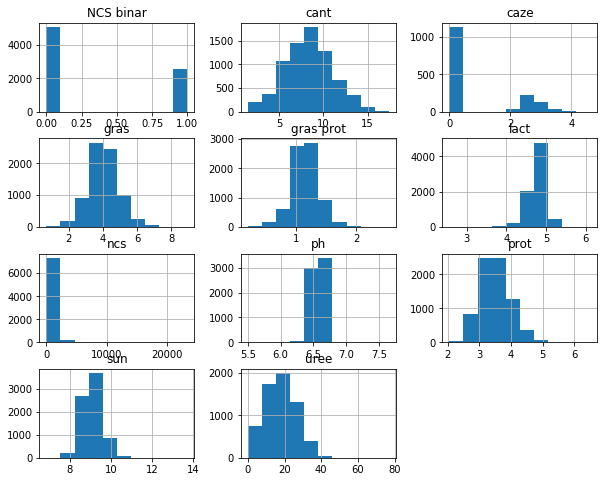

In [0]:
# NULL data histogram
df_null.hist()

## Get the NON-NULL data

In [0]:
df_non_null = df[~pd.isnull(df).any(axis=1)]

In [0]:
df_non_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 4003 to 235
Data columns (total 11 columns):
cant         6097 non-null float64
caze         6097 non-null float64
gras         6097 non-null float64
lact         6097 non-null float64
ncs          6097 non-null float64
ph           6097 non-null float64
prot         6097 non-null float64
gras prot    6097 non-null float64
sun          6097 non-null float64
uree         6097 non-null float64
NCS binar    6097 non-null float64
dtypes: float64(11)
memory usage: 571.6 KB


In [0]:
df_non_null.describe()

,cant,caze,gras,lact,ncs,ph,prot,gras prot,sun,uree,NCS binar
count,6097.000000,6097.000000,6097.000000,6097.000000,6097.00000,6097.000000,6097.000000,6097.000000,6097.000000,6097.000000,6097.000000
mean,7.711940,2.225511,4.093354,4.698296,433.93341,6.582782,3.518242,1.168295,9.014404,20.248106,0.331146
std,2.661818,1.140497,0.932236,0.248591,1224.10183,0.125730,0.458590,0.245234,0.481920,11.422000,0.470664
min,1.500000,0.000000,0.410000,2.400000,2.00000,5.610000,2.140000,0.103535,6.800000,0.100000,0.000000
25%,6.000000,2.270000,3.530000,4.600000,45.00000,6.530000,3.200000,1.033113,8.710000,10.900000,0.000000
50%,7.500000,2.640000,4.090000,4.730000,104.00000,6.590000,3.500000,1.168539,9.000000,19.400000,0.000000
75%,9.300000,2.920000,4.660000,4.850000,283.00000,6.640000,3.810000,1.304469,9.310000,28.200000,1.000000
max,19.000000,5.420000,9.850000,8.310000,20796.00000,13.340000,7.110000,2.705036,16.940000,78.600000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f470a92a208>,
      dtype=object)

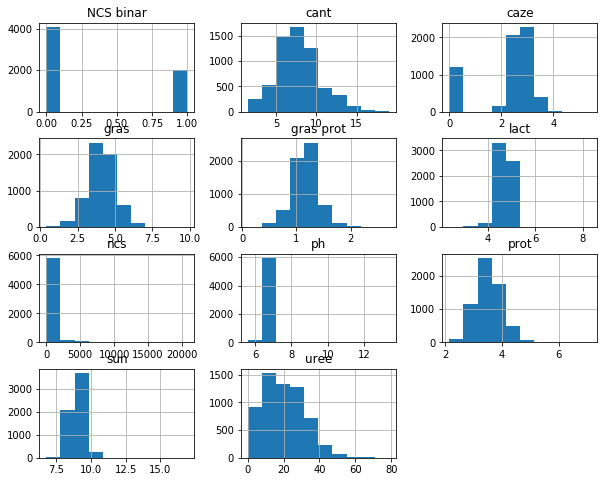

In [0]:
df_non_null.hist()

In [0]:
df_null.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f470b1e3828>,
      dtype=object)

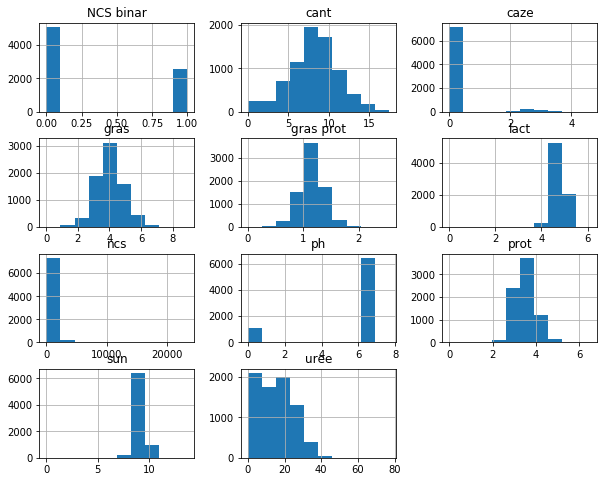

In [0]:
df_null.hist()

#Explore the data

In [0]:
df.head()

,cant,caze,gras,lact,ncs,ph,prot,gras prot,sun,uree,NCS binar
4003,12.0,2.69,5.24,4.57,106.0,6.62,3.36,1.559524,8.60,3.7,0.0
10445,7.0,2.78,5.49,4.73,4555.0,6.62,3.44,1.595930,8.88,3.5,1.0
12002,11.0,NaN,4.84,4.82,17.0,6.62,3.29,1.471125,9.05,23.2,0.0
5440,10.0,NaN,4.12,5.14,17.0,6.67,3.23,1.275542,9.22,30.3,0.0
6034,9.9,NaN,4.73,4.65,157.0,6.61,3.38,1.399408,8.96,11.4,0.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13687 entries, 4003 to 13349
Data columns (total 11 columns):
cant         13445 non-null float64
caze         7675 non-null float64
gras         13686 non-null float64
lact         13686 non-null float64
ncs          13686 non-null float64
ph           12554 non-null float64
prot         13686 non-null float64
gras prot    13686 non-null float64
sun          13686 non-null float64
uree         12345 non-null float64
NCS binar    13686 non-null float64
dtypes: float64(11)
memory usage: 1.3 MB


In [0]:
df_null = df[pd.isnull(df).any(axis=1)]

In [0]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 12002 to 13349
Data columns (total 11 columns):
cant         7348 non-null float64
caze         1578 non-null float64
gras         7589 non-null float64
lact         7589 non-null float64
ncs          7589 non-null float64
ph           6457 non-null float64
prot         7589 non-null float64
gras prot    7589 non-null float64
sun          7589 non-null float64
uree         6248 non-null float64
NCS binar    7589 non-null float64
dtypes: float64(11)
memory usage: 711.6 KB


In [0]:
df['NCS binar'] = df['NCS binar'].astype('category')
df_non_null['NCS binar'] = df_non_null['NCS binar'].astype('category')
cat_cols = ['NCS binar']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df_non_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 4003 to 235
Data columns (total 11 columns):
cant         6097 non-null float64
caze         6097 non-null float64
gras         6097 non-null float64
lact         6097 non-null float64
ncs          6097 non-null float64
ph           6097 non-null float64
prot         6097 non-null float64
gras prot    6097 non-null float64
sun          6097 non-null float64
uree         6097 non-null float64
NCS binar    6097 non-null category
dtypes: category(1), float64(10)
memory usage: 530.0 KB


# Make data become missing

In [0]:
from sklearn.utils import resample
prob_missing = 0.3
df_incomplete = df_non_null.copy()
ix = [(row, col) for row in range(df_non_null.shape[0]) for col in range(df_non_null.shape[1])]
L = resample(ix, n_samples = int(prob_missing*len(ix)), random_state=LOCAL_SEED)
for row, col in L:
    df_incomplete.iat[row, col] = np.nan

In [0]:
df_incomplete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 4003 to 235
Data columns (total 11 columns):
cant         5514 non-null float64
caze         5511 non-null float64
gras         5527 non-null float64
lact         5540 non-null float64
ncs          5534 non-null float64
ph           5523 non-null float64
prot         5530 non-null float64
gras prot    5496 non-null float64
sun          5511 non-null float64
uree         5504 non-null float64
NCS binar    5474 non-null category
dtypes: category(1), float64(10)
memory usage: 530.0 KB


In [0]:
missing_encoded = pd.get_dummies(df_incomplete)

for col in df.columns:
    missing_cols = missing_encoded.columns.str.startswith(str(col) + "_")
    missing_encoded.loc[df_incomplete[col].isnull(), missing_cols] = np.nan

In [0]:
missing_encoded.head()

,cant,caze,gras,lact,ncs,ph,prot,gras prot,sun,uree,NCS binar_0.0,NCS binar_1.0
4003,12.0,2.69,5.24,4.57,106.0,6.62,3.36,1.559524,8.60,3.7,1.0,0.0
10445,7.0,2.78,5.49,4.73,4555.0,6.62,3.44,1.595930,8.88,3.5,0.0,1.0
2063,7.0,0.00,3.97,4.83,158.0,6.61,NaN,1.121469,9.21,33.7,1.0,0.0
6571,2.3,0.00,4.42,4.29,634.0,6.54,4.03,1.096774,9.23,16.1,0.0,1.0
3796,5.7,0.00,4.54,4.62,105.0,6.59,3.55,1.278873,9.10,28.2,1.0,0.0


In [0]:
hidden_size = 1000
n_epochs = 100
n_batch_size=1024

In [0]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

In [0]:
def reverse_encoding(df_test_dummies):
    names = list(df_test_dummies)
    c_dict = {}
    for n in names:
        if '_' in n:
            index = n.index('_')
            c_dict[n[:index]] = [c for c in names if n[:index+1] in c]
    values = []
    for key, items in c_dict.items():
        dummies = df_test_dummies[items]
        d_names = list(dummies)
        c_dict = {}
        for n in d_names:
            c_dict[n] = n[n.index('_')+1:]
        dummies.rename(columns=c_dict, 
                    inplace=True)
        df_test_dummies[key] = dummies.idxmax(axis=1)
        df_test_dummies.drop(items, axis=1, inplace=True)
    print(df_test_dummies.head())
    return df_test_dummies

# AutoEncoder with Dropout

In [0]:
from sklearn.model_selection import train_test_split
values = missing_encoded.values.copy()
train, test, comp_train, comp_test = train_test_split(values,
                                                      df_non_null.values.copy(),
                                                      test_size=0.1,
                                                      random_state=LOCAL_SEED)
scaler = MinMaxScaler().fit(train)
x_train = scaler.transform(train)
x_test = scaler.transform(test)
n_dims = x_train.shape[1]

In [0]:
cols = df_non_null.columns
df_test_complete = pd.DataFrame(columns=cols, 
                                data=comp_test)

In [0]:
class AutoEncoderDropout:
    def __init__(self, 
                 n_dims,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.5,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l1_penalty=1e-3,
                 l2_penalty=1e-3,
                 hidden_size=hidden_size):
        self.n_dims = n_dims
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.hidden_size = hidden_size

    def make_reconstruction_loss(self, n_features):
        def reconstruction_loss(input_and_mask, y_pred):
            X_values = input_and_mask[:, :n_features]
            missing_mask = input_and_mask[:, n_features:]
            observed_mask = 1 - missing_mask
            X_values_observed = X_values * observed_mask
            pred_observed = y_pred * observed_mask
            return binary_crossentropy(y_true=X_values_observed, 
                                       y_pred=pred_observed)
        return reconstruction_loss

    def _create_model(self):
        latent_dim = int(np.ceil(self.n_dims*0.5))
        inputs = Input(shape=(2*self.n_dims, ), 
                       name='encoder_input')
        x = inputs
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        encoded = Dense(latent_dim, name='encoding')(x)
        self.encoder = Model(inputs, encoded, name='encoder')
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = latent_inputs
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        outputs = Dense(self.n_dims, activation=self.output_activation,
                        init=self.init,
                        kernel_regularizer=l2(self.l2_penalty),
                        bias_regularizer=l2(self.l2_penalty))(x)
        self.decoder = Model(latent_inputs, 
                             outputs, 
                             name='decoder')
        outputs = self.decoder(self.encoder(inputs))
        self.model = Model(inputs, outputs, name='ae_mlp')
        loss_function = self.make_reconstruction_loss(self.n_dims)
        self.model.compile(optimizer=self.optimizer, 
                           loss=loss_function)

    def fill(self, data, missing_mask):
        data[missing_mask] = -1
        return data

    def _create_missing_mask(self, data):
        if data.dtype != "f" and data.dtype != "d":
            data = data.astype(float)
        return np.isnan(data)

    def _train_epoch(self, data, missing_mask, batch_size):
        input_with_mask = np.hstack([data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            self.model.train_on_batch(batch_data, batch_data)
        return self.model.predict(input_with_mask)
    
    def predict(self, x_test_with_mask):
        predict_stochastic = K.function([self.decoder.layers[0].input,
                                        K.learning_phase()],
                                        [self.decoder.layers[-1].output])
        latent_input = self.encoder.predict(x_test_with_mask)

        outputs = np.array([np.array(predict_stochastic([latent_input, 
                                                         1])).reshape((x_test_with_mask.shape[0], 
                                                                       x_test_with_mask.shape[1]//2)) for _ in range(50)])
        return np.mean(outputs, axis=0)

    def predict_dist(self, x_test, n_epochs=50):
        predict_stochastic = K.function([self.decoder.layers[0].input,
                                        K.learning_phase()],
                                        [self.decoder.layers[-1].output])
        x_test_missing_mask = self._create_missing_mask(x_test) 
        x_test = self.fill(x_test, x_test_missing_mask)
        x_test_observed_mask = ~x_test_missing_mask
        x_test_with_mask = np.hstack([x_test, x_test_missing_mask])
        latent_input = self.encoder.predict(x_test_with_mask)
        X_test_pred = np.array([predict_stochastic([latent_input, 1])])
        X_test_pred = X_test_pred.reshape((x_test.shape[0], x_test.shape[1]))
        print(X_test_pred.shape)
        for _ in range(n_epochs):
            old_weight = (1.0 - self.recurrent_weight)
            x_test[x_test_missing_mask] *= old_weight
            x_test_pred_missing = X_test_pred[x_test_missing_mask]
            x_test[x_test_missing_mask] += self.recurrent_weight * x_test_pred_missing
        return x_test

    def train(self, x_train, x_test, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask(x_train)
        x_train = self.fill(x_train, missing_mask)
        x_test_missing_mask = self._create_missing_mask(x_test) 
        x_test = self.fill(x_test, x_test_missing_mask)

        self._create_model()
        
        observed_mask = ~missing_mask
        x_test_observed_mask = ~x_test_missing_mask
        input_with_mask = np.hstack([x_train, missing_mask])
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(x_train, missing_mask, batch_size)
            x_test_with_mask = np.hstack([x_test, x_test_missing_mask])
            X_test_pred = self.predict(x_test_with_mask)
            observed_mae = masked_mae(X_true=x_train,
                                    X_pred=X_pred,
                                    mask=observed_mask)
            test_observed_mae = masked_mae(X_true=x_test,
                                           X_pred = X_test_pred,
                                           mask=x_test_observed_mask)
            if epoch % 50 == 0:
                print("observed mae:", observed_mae)
                print("Test mae:", test_observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            x_train[missing_mask] *= old_weight
            x_test[x_test_missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            x_test_pred_missing = X_test_pred[x_test_missing_mask]
            x_train[missing_mask] += self.recurrent_weight * pred_missing
            x_test[x_test_missing_mask] += self.recurrent_weight * x_test_pred_missing
        return x_train.copy(), x_test.copy()

In [0]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
seeds = [LOCAL_SEED+2, LOCAL_SEED+1, LOCAL_SEED+4, LOCAL_SEED+6, LOCAL_SEED+8]
rmses = []
cols = df_non_null.columns
non_null_values = df_non_null.values.copy()
for seed_number in seeds:
    values = missing_encoded.values.copy()
    train, test, comp_train, comp_test = train_test_split(values.copy(),
                                                        non_null_values.copy(),
                                                        test_size=0.1,
                                                        random_state=seed_number)
    df_test_complete = pd.DataFrame(columns=cols, 
                                    data=comp_test.copy())
    scaler = MinMaxScaler().fit(train)
    x_train = scaler.transform(train)
    x_test = scaler.transform(test)
    n_dims = x_train.shape[1]
    aedropout = AutoEncoderDropout(n_dims=n_dims)
    complete_encoded = aedropout.train(x_train.copy(), 
                                    x_test.copy(), 
                                    train_epochs=n_epochs,
                                    batch_size=n_batch_size)
    train_encoded, test_encoded = complete_encoded
    missing_cols = list(missing_encoded)
    inverse_test_encoded = scaler.inverse_transform(test_encoded)
    df_test_dummies = pd.DataFrame(columns=missing_cols, 
                                   data=inverse_test_encoded)
    df_test_dummies = reverse_encoding(df_test_dummies.copy())
    df_test_dummies.drop(cat_cols, axis=1,
                         inplace=True)
    df_test_complete.drop(cat_cols, axis=1,
                          inplace=True)
    true_vals = df_test_complete.values.copy()
    test_vals = df_test_dummies.values.copy()
    scaler2 = MinMaxScaler().fit(true_vals)
    scaled_true_vales = scaler2.transform(true_vals)
    scaled_test_vales = scaler2.transform(test_vals)
    rmse = math.sqrt(mean_squared_error(scaled_true_vales, 
                                        scaled_test_vales))
    rmses.append(rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_

observed mae: 0.2617217162174475
Test mae: 0.2617642375087819
observed mae: 0.06435300333636668
Test mae: 0.06411093746888656


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

   cant  caze      gras  lact  ...  gras prot   sun  uree  NCS binar
0   6.0  2.63  3.710000  4.57  ...   1.100890  8.49  16.1        0.0
1   8.2  0.00  4.950000  4.36  ...   1.148492  9.67   7.5        0.0
2  11.2  2.20  4.010000  4.80  ...   1.197351  8.27   7.3        0.0
3   5.8  2.77  4.233865  4.36  ...   1.196362  8.69  16.1        1.0
4  11.0  2.57  4.198679  4.59  ...   1.185410  8.57   9.5        1.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


observed mae: 0.24345194129456324
Test mae: 0.24140620632244106
observed mae: 0.06330294044138392
Test mae: 0.06422688514971069


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

        cant  caze  gras  lact  ...  gras prot   sun       uree  NCS binar
0  11.700000  2.17  3.87  4.75  ...   1.382143  8.33   3.900000        0.0
1   8.227348  3.14  4.41  4.13  ...   1.037647  9.06  26.700000        0.0
2  11.000000  2.36  3.23  4.72  ...   1.117647  8.57  33.700000        0.0
3  11.000000  2.10  5.15  4.67  ...   1.921642  8.09  20.133004        1.0
4   8.000000  2.90  4.63  4.74  ...   1.258152  9.22  24.900000        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


observed mae: 0.2461785437964436
Test mae: 0.24507674505742255
observed mae: 0.06482985792533762
Test mae: 0.0649073883878365


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

        cant  caze      gras      lact  ...  gras prot   sun       uree  NCS binar
0   6.300000  0.00  2.420000  4.320000  ...   0.735562  8.47  28.000000        0.0
1   8.271418  3.09  4.042247  4.630000  ...   1.132812  9.45  24.400000        0.0
2   7.000839  2.69  4.214032  4.790000  ...   1.521994  8.79  19.992267        1.0
3   5.000000  3.41  5.670000  4.545609  ...   1.186769  9.63  28.600000        1.0
4  10.100000  2.56  2.900000  4.880000  ...   0.909091  8.90  13.900000        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


observed mae: 0.21860669124369142
Test mae: 0.21421721243433026
observed mae: 0.06412764412495861
Test mae: 0.06276656398768861


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

   cant  caze      gras  lact  ...  gras prot      sun  uree  NCS binar
0   5.7  3.35  6.940000  4.63  ...   1.648456  9.60000   8.1        1.0
1   6.3  3.07  4.650000  4.99  ...   1.207792  9.45000  29.7        1.0
2   6.5  0.00  3.860000  4.73  ...   1.099715  9.12000  13.0        0.0
3   7.5  2.60  3.810000  5.06  ...   1.175926  9.00769  16.2        0.0
4   8.0  2.56  4.017597  4.77  ...   1.154762  9.04000   9.3        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


observed mae: 0.20154831774091414
Test mae: 0.19656294951191067
observed mae: 0.06500459403988243
Test mae: 0.06478828433086713
   cant      caze  gras  lact  ...  gras prot    sun  uree  NCS binar
0   7.2  3.070000  4.29  4.65  ...   1.120104   9.42  35.0        0.0
1   7.4  0.000000  4.66  4.67  ...   1.219895   9.31  23.9        1.0
2  13.4  2.282143  2.89  4.56  ...   0.894737   8.53  36.3        0.0
3   3.6  3.430000  4.73  5.02  ...   1.075000  10.16   5.5        0.0
4   5.0  2.410000  4.95  4.38  ...   1.581470   8.19  28.1        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
print(np.mean(rmses), np.std(rmses))

0.04799002261068887 0.0015991057431794897


# VAE MCD

In [0]:
from sklearn.model_selection import train_test_split
values = missing_encoded.values.copy()
train, test, comp_train, comp_test = train_test_split(values,
                                                      df_non_null.values.copy(),
                                                      test_size=0.1,
                                                      random_state=LOCAL_SEED)
scaler = MinMaxScaler().fit(train)
x_train = scaler.transform(train)
x_test = scaler.transform(test)
n_dims = x_train.shape[1]

In [0]:
class VAEDropout:
    def __init__(self, n_dims,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.5,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l2_penalty=1e-3,
                 hidden_size=hidden_size):
        self.n_dims = n_dims
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l2_penalty = l2_penalty
        self.hidden_size = hidden_size
        self._create_model()

    def _create_model(self):
        latent_dim = int(np.ceil(self.n_dims*0.5))
        inputs = Input(shape=(2*n_dims, ), name='encoder_input')
        x = inputs
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        self.encoder = Model(inputs, [z_mean, 
                                      z_log_var], name='encoder')
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = latent_inputs
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init,
                  kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                 init=self.init,
                 kernel_regularizer=l2(self.l2_penalty),
                  bias_regularizer=l2(self.l2_penalty))(x)
        x = Dropout(self.dropout_probability)(x)
        outputs = Dense(self.n_dims, activation=self.output_activation,
                        init=self.init,
                       kernel_regularizer=l2(self.l2_penalty),
                        bias_regularizer=l2(self.l2_penalty))(x)
        self.decoder = Model(latent_inputs, 
                             outputs, 
                             name='decoder')
        outputs = self.decoder(self.encoder(inputs)[0]) # Just take the mean
        self.model = Model(inputs, outputs, 
                           name='vae_mlp')
        reconstruction_loss = self.make_vae_reconstruction_loss(n_dims, 
                                                       z_mean, 
                                                       z_log_var)
        self.model.compile(optimizer=self.optimizer, 
                           loss=reconstruction_loss)

    def make_vae_reconstruction_loss(self, n_features, z_mean, z_log_var):
        def reconstruction_loss(input_and_mask, y_pred):
            X_values = input_and_mask[:, :n_features]
        
            missing_mask = input_and_mask[:, n_features:]
            observed_mask = 1 - missing_mask
            X_values_observed = X_values * observed_mask
            pred_observed = y_pred * observed_mask
            reconstruction_loss = binary_crossentropy(y_true=X_values_observed, 
                                        y_pred=pred_observed)
            reconstruction_loss*=n_features
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            vae_loss = K.mean(reconstruction_loss + kl_loss)	
            return vae_loss
        return reconstruction_loss

    def fill(self, data, missing_mask):
        data[missing_mask] = -1
        return data

    def _create_missing_mask(self, data):
        if data.dtype != "f" and data.dtype != "d":
            data = data.astype(float)
        return np.isnan(data)

    def predict(self, x_test_with_mask):
        predict_stochastic = K.function([self.decoder.layers[0].input,
                                        K.learning_phase()],
                                        [self.decoder.layers[-1].output])
        latent_input = self.encoder.predict(x_test_with_mask)[0]
        outputs = np.array([np.array(predict_stochastic([latent_input,
                                                         1])).reshape((x_test_with_mask.shape[0],
                                                                                     x_test_with_mask.shape[1]//2)) for _ in range(50)])
        return np.mean(outputs, axis=0)

    def _train_epoch(self, data, missing_mask, batch_size):
        input_with_mask = np.hstack([data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            self.model.train_on_batch(batch_data, batch_data)
        return self.model.predict(input_with_mask)

    def train(self, x_train, x_test, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask(x_train)
        x_train = self.fill(x_train, missing_mask)
        x_test_missing_mask = self._create_missing_mask(x_test) 
        x_test = self.fill(x_test, x_test_missing_mask)
        observed_mask = ~missing_mask
        x_test_observed_mask = ~x_test_missing_mask
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(x_train, missing_mask, batch_size)
            x_test_with_mask = np.hstack([x_test, x_test_missing_mask])
            X_test_pred = self.predict(x_test_with_mask)
            observed_mae = masked_mae(X_true=x_train,
                                      X_pred=X_pred,
                                      mask=observed_mask)
            test_observed_mae = masked_mae(X_true=x_test,
                                X_pred = X_test_pred,
                                mask=x_test_observed_mask)
            if epoch % 50 == 0:
                print("Traing observed mae:", observed_mae)
                print("Test observed mae:", test_observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            x_train[missing_mask] *= old_weight
            x_test[x_test_missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            x_test_pred_missing = X_test_pred[x_test_missing_mask]
            x_train[missing_mask] += self.recurrent_weight * pred_missing
            x_test[x_test_missing_mask] += self.recurrent_weight*x_test_pred_missing
        return x_train.copy(), x_test.copy()

In [0]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
seeds = [LOCAL_SEED+2, LOCAL_SEED+1, LOCAL_SEED+4, LOCAL_SEED+6, LOCAL_SEED+8]
rmses = []
cols = df_non_null.columns
non_null_values = df_non_null.values.copy()
for seed_number in seeds:
    values = missing_encoded.values.copy()
    train, test, comp_train, comp_test = train_test_split(values.copy(),
                                                        non_null_values.copy(),
                                                        test_size=0.1,
                                                        random_state=seed_number)
    df_test_complete = pd.DataFrame(columns=cols, 
                                    data=comp_test.copy())
    scaler = MinMaxScaler().fit(train)
    x_train = scaler.transform(train)
    x_test = scaler.transform(test)
    n_dims = x_train.shape[1]
    aedropout = VAEDropout(n_dims=n_dims)
    complete_encoded = aedropout.train(x_train.copy(), 
                                    x_test.copy(), 
                                    train_epochs=n_epochs,
                                    batch_size=n_batch_size)
    train_encoded, test_encoded = complete_encoded
    missing_cols = list(missing_encoded)
    inverse_test_encoded = scaler.inverse_transform(test_encoded)
    df_test_dummies = pd.DataFrame(columns=missing_cols, 
                                   data=inverse_test_encoded)
    df_test_dummies = reverse_encoding(df_test_dummies.copy())
    df_test_dummies.drop(cat_cols, axis=1,
                         inplace=True)
    df_test_complete.drop(cat_cols, axis=1,
                          inplace=True)
    true_vals = df_test_complete.values.copy()
    test_vals = df_test_dummies.values.copy()
    scaler2 = MinMaxScaler().fit(true_vals)
    scaled_true_vales = scaler2.transform(true_vals)
    scaled_test_vales = scaler2.transform(test_vals)
    rmse = math.sqrt(mean_squared_error(scaled_true_vales, 
                                        scaled_test_vales))
    rmses.append(rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_

Traing observed mae: 0.22660911977275913
Test observed mae: 0.22531270232303727
Traing observed mae: 0.036607300745461244
Test observed mae: 0.036820914448346544


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

   cant  caze      gras  lact  ...  gras prot   sun  uree  NCS binar
0   6.0  2.63  3.710000  4.57  ...   1.100890  8.49  16.1        0.0
1   8.2  0.00  4.950000  4.36  ...   1.148492  9.67   7.5        0.0
2  11.2  2.20  4.010000  4.80  ...   1.184630  8.27   7.3        0.0
3   5.8  2.77  4.291581  4.36  ...   1.174942  8.69  16.1        1.0
4  11.0  2.57  4.046769  4.59  ...   1.185410  8.57   9.5        1.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


Traing observed mae: 0.24886417266699817
Test observed mae: 0.24727365970526735
Traing observed mae: 0.04366566089960063
Test observed mae: 0.04416542304850564


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

        cant  caze  gras  lact  ...  gras prot   sun       uree  NCS binar
0  11.700000  2.17  3.87  4.75  ...   1.382143  8.33   3.900000        0.0
1   5.591596  3.14  4.41  4.13  ...   1.037647  9.06  26.700000        0.0
2  11.000000  2.36  3.23  4.72  ...   1.117647  8.57  33.700000        0.0
3  11.000000  2.10  5.15  4.67  ...   1.921642  8.09  18.536514        1.0
4   8.000000  2.90  4.63  4.74  ...   1.258152  9.22  24.900000        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


Traing observed mae: 0.2519431198443704
Test observed mae: 0.2517121552289873
Traing observed mae: 0.036492242590507956
Test observed mae: 0.0378104743295788


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

        cant  caze      gras      lact  ...  gras prot   sun      uree  NCS binar
0   6.300000  0.00  2.420000  4.320000  ...   0.735562  8.47  28.00000        0.0
1   6.815742  3.09  4.223087  4.630000  ...   1.132812  9.45  24.40000        0.0
2   8.579557  2.69  3.823060  4.790000  ...   1.521994  8.79  32.03881        1.0
3   5.000000  3.41  5.670000  4.513451  ...   1.088976  9.63  28.60000        1.0
4  10.100000  2.56  2.900000  4.880000  ...   0.909091  8.90  13.90000        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


Traing observed mae: 0.25284541918704284
Test observed mae: 0.25058595693299685
Traing observed mae: 0.03612812295254475
Test observed mae: 0.03553275835305286


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", ke

   cant  caze      gras  lact  ...  gras prot       sun  uree  NCS binar
0   5.7  3.35  6.940000  4.63  ...   1.648456  9.600000   8.1        1.0
1   6.3  3.07  4.650000  4.99  ...   1.207792  9.450000  29.7        1.0
2   6.5  0.00  3.860000  4.73  ...   1.099715  9.120000  13.0        0.0
3   7.5  2.60  3.810000  5.06  ...   1.175926  8.917086  16.2        0.0
4   8.0  2.56  4.148563  4.77  ...   1.154762  9.040000   9.3        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="sigmoid", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`


Traing observed mae: 0.23455197377072015
Test observed mae: 0.23349151702541465
Traing observed mae: 0.035773413910223116
Test observed mae: 0.0359704733719995
   cant      caze  gras  lact  ...  gras prot    sun  uree  NCS binar
0   7.2  3.070000  4.29  4.65  ...   1.120104   9.42  35.0        0.0
1   7.4  0.000000  4.66  4.67  ...   1.219895   9.31  23.9        1.0
2  13.4  2.302931  2.89  4.56  ...   0.894737   8.53  36.3        0.0
3   3.6  3.430000  4.73  5.02  ...   1.075000  10.16   5.5        0.0
4   5.0  2.410000  4.95  4.38  ...   1.581470   8.19  28.1        0.0

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
print(np.mean(rmses), np.std(rmses))

0.04655965742248365 0.0012359338368721727


# AutoEncoder

In [0]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

In [0]:
from sklearn.model_selection import train_test_split
values = missing_encoded.values.copy()
train, test, comp_train, comp_test = train_test_split(values,
                                                      df_non_null.values.copy(),
                                                      test_size=0.1,
                                                      random_state=LOCAL_SEED)
scaler = MinMaxScaler().fit(train)
x_train = scaler.transform(train)
x_test = scaler.transform(test)

In [0]:
class Autoencoder:
    def __init__(self, n_dims,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.1,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l1_penalty=0,
                 l2_penalty=1e-3,
                 hidden_size=hidden_size):
        self.n_dims = n_dims
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.hidden_size = hidden_size

    def make_reconstruction_loss(self, n_features):
    
        def reconstruction_loss(input_and_mask, y_pred):
            X_values = input_and_mask[:, :n_features]
            missing_mask = input_and_mask[:, n_features:]
            observed_mask = 1 - missing_mask
            X_values_observed = X_values * observed_mask
            pred_observed = y_pred * observed_mask
            return binary_crossentropy(y_true=X_values_observed, 
                                       y_pred=pred_observed)
        return reconstruction_loss

    def _create_model(self):
        latent_dim = int(np.ceil(self.n_dims*0.5))
        inputs = Input(shape=(2*n_dims, ), name='encoder_input')
        x = inputs
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        encoded = Dense(latent_dim, name='encoding')(x)
        self.encoder = Model(inputs, encoded, name='encoder')
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = latent_inputs
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        outputs = Dense(n_dims, activation=self.output_activation)(x)
        self.decoder = Model(latent_inputs, 
                             outputs, 
                             name='decoder')
        outputs = self.decoder(self.encoder(inputs))
        self.model = Model(inputs, outputs, name='vae_mlp')
        loss_function = self.make_reconstruction_loss(n_dims)
        self.model.compile(optimizer=self.optimizer, 
                           loss=loss_function)

    def fill(self, data, missing_mask):
        data[missing_mask] = -1
        return data

    def _create_missing_mask(self, data):
        if data.dtype != "f" and data.dtype != "d":
            data = data.astype(float)

        return np.isnan(data)

    def _train_epoch(self, data, missing_mask, batch_size):
        input_with_mask = np.hstack([data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            self.model.train_on_batch(batch_data, batch_data)
        return self.model.predict(input_with_mask)

    def train(self, x_train, x_test, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask(x_train)
        x_train = self.fill(x_train, missing_mask)
        x_test_missing_mask = self._create_missing_mask(x_test) 
        x_test = self.fill(x_test, x_test_missing_mask)
        self._create_model()
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()
        observed_mask = ~missing_mask
        x_test_observed_mask = ~x_test_missing_mask
        input_with_mask = np.hstack([x_train, missing_mask])
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(x_train, missing_mask, batch_size)
            x_test_with_mask = np.hstack([x_test, x_test_missing_mask])
            X_test_pred = self.model.predict(x_test_with_mask)
            observed_mae = masked_mae(X_true=x_train,
                                    X_pred=X_pred,
                                    mask=observed_mask)
            test_observed_mae = masked_mae(X_true=x_test,
                                           X_pred = X_test_pred,
                                           mask=x_test_observed_mask)
            if epoch % 50 == 0:
                print("observed mae:", observed_mae)
                print("Test mae:", test_observed_mae)

            old_weight = (1.0 - self.recurrent_weight)
            x_train[missing_mask] *= old_weight
            x_test[x_test_missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            x_test_pred_missing = X_test_pred[x_test_missing_mask]
            x_train[missing_mask] += self.recurrent_weight * pred_missing
            x_test[x_test_missing_mask] += self.recurrent_weight * x_test_pred_missing
        return x_train.copy(), x_test.copy()

In [0]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
seeds = [LOCAL_SEED+2, LOCAL_SEED+1, LOCAL_SEED+4, LOCAL_SEED+6, LOCAL_SEED+8]
rmses = []
cols = df_non_null.columns
non_null_values = df_non_null.values.copy()
for seed_number in seeds:
    values = missing_encoded.values.copy()
    train, test, comp_train, comp_test = train_test_split(values.copy(),
                                                        non_null_values.copy(),
                                                        test_size=0.1,
                                                        random_state=seed_number)
    df_test_complete = pd.DataFrame(columns=cols, 
                                    data=comp_test.copy())
    scaler = MinMaxScaler().fit(train)
    x_train = scaler.transform(train)
    x_test = scaler.transform(test)
    n_dims = x_train.shape[1]
    aedropout = Autoencoder(n_dims=n_dims)
    complete_encoded = aedropout.train(x_train.copy(), 
                                    x_test.copy(), 
                                    train_epochs=n_epochs,
                                    batch_size=n_batch_size)
    train_encoded, test_encoded = complete_encoded
    missing_cols = list(missing_encoded)
    inverse_test_encoded = scaler.inverse_transform(test_encoded)
    df_test_dummies = pd.DataFrame(columns=missing_cols, 
                                   data=inverse_test_encoded)
    df_test_dummies = reverse_encoding(df_test_dummies.copy())
    df_test_dummies.drop(cat_cols, axis=1,
                         inplace=True)
    df_test_complete.drop(cat_cols, axis=1,
                          inplace=True)
    true_vals = df_test_complete.values.copy()
    test_vals = df_test_dummies.values.copy()
    scaler2 = MinMaxScaler().fit(true_vals)
    scaled_true_vales = scaler2.transform(true_vals)
    scaled_test_vales = scaler2.transform(test_vals)
    rmse = math.sqrt(mean_squared_error(scaled_true_vales, 
                                        scaled_test_vales))
    rmses.append(rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1000)              25000     
_________________________________________________________________
dropout_45 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 250)               250250    
_________________________________________________________________
dropout_46 (Dropout)         (None, 250)               0         
_________________________________________________________________
encoding (Dense)             (None, 6)                 1506      
Total params: 276,756
Trainable params: 276,756
Non-trainable params: 0
_____________________________________________________

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense`

   cant  caze      gras  lact  ...  gras prot   sun  uree  NCS binar
0   6.0  2.63  3.710000  4.57  ...   1.100890  8.49  16.1        0.0
1   8.2  0.00  4.950000  4.36  ...   1.148492  9.67   7.5        0.0
2  11.2  2.20  4.010000  4.80  ...   1.430167  8.27   7.3        0.0
3   5.8  2.77  2.691558  4.36  ...   0.744866  8.69  16.1        1.0
4  11.0  2.57  3.823616  4.59  ...   1.185410  8.57   9.5        1.0

[5 rows x 11 columns]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 1000)              25000     
_________________________________________________________________
dropout_49 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_62 (Dense)  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense`

       cant  caze  gras  lact  ...  gras prot   sun       uree  NCS binar
0  11.70000  2.17  3.87  4.75  ...   1.382143  8.33   3.900000        0.0
1   6.21388  3.14  4.41  4.13  ...   1.037647  9.06  26.700000        0.0
2  11.00000  2.36  3.23  4.72  ...   1.117647  8.57  33.700000        0.0
3  11.00000  2.10  5.15  4.67  ...   1.921642  8.09  16.927547        1.0
4   8.00000  2.90  4.63  4.74  ...   1.258152  9.22  24.900000        0.0

[5 rows x 11 columns]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1000)              25000     
_________________________________________________________________
dropout_53 (Dropout)         (None, 1000)              0         
______________________________________________________

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense`

        cant  caze      gras      lact  ...  gras prot   sun       uree  NCS binar
0   6.300000  0.00  2.420000  4.320000  ...   0.735562  8.47  28.000000        1.0
1   6.566512  3.09  4.521131  4.630000  ...   1.132812  9.45  24.400000        0.0
2   8.011668  2.69  4.808068  4.790000  ...   1.521994  8.79   6.751478        1.0
3   5.000000  3.41  5.670000  4.446279  ...   1.303050  9.63  28.600000        1.0
4  10.100000  2.56  2.900000  4.880000  ...   0.909091  8.90  13.900000        0.0

[5 rows x 11 columns]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 1000)              25000     
_________________________________________________________________
dropout_57 (Dropout)         (None, 1000)              0         


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense`

   cant  caze      gras  lact  ...  gras prot       sun  uree  NCS binar
0   5.7  3.35  6.940000  4.63  ...   1.648456  9.600000   8.1        1.0
1   6.3  3.07  4.650000  4.99  ...   1.207792  9.450000  29.7        1.0
2   6.5  0.00  3.860000  4.73  ...   1.099715  9.120000  13.0        0.0
3   7.5  2.60  3.810000  5.06  ...   1.175926  9.018045  16.2        0.0
4   8.0  2.56  3.895984  4.77  ...   1.154762  9.040000   9.3        0.0

[5 rows x 11 columns]
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 1000)              25000     
_________________________________________________________________
dropout_61 (Dropout)         (None, 1000)              0         
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
print(np.mean(rmses), np.std(rmses))

0.053652362168770826 0.0011674074651310039


# VAE

In [0]:
from sklearn.model_selection import train_test_split
values = missing_encoded.values.copy()
train, test, comp_train, comp_test = train_test_split(values,
                                                      df_non_null.values.copy(),
                                                      test_size=0.1,
                                                      random_state=LOCAL_SEED)
scaler = MinMaxScaler().fit(train)
x_train = scaler.transform(train)
x_test = scaler.transform(test)

In [0]:
class VAE:

    def __init__(self, n_dims,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.1,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l2_penalty=1e-3):
        self.n_dims = n_dims
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l2_penalty = l2_penalty
        self.hidden_size = hidden_size
        self._create_model()

    def make_reconstruction_loss(self, n_features, z_mean, z_log_var):
        def reconstruction_loss(input_and_mask, y_pred):
            X_values = input_and_mask[:, :n_features]
            missing_mask = input_and_mask[:, n_features:]
            observed_mask = 1 - missing_mask
            X_values_observed = X_values * observed_mask
            pred_observed = y_pred * observed_mask
            reconstruction_loss = binary_crossentropy(y_true=X_values_observed, 
                                        y_pred=pred_observed)
            reconstruction_loss*=n_features
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            vae_loss = K.mean(reconstruction_loss + kl_loss)	
            return vae_loss
        return reconstruction_loss

    def sampling(self, args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """
    
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean = 0 and std = 1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def _create_model(self):
        latent_dim = (int(np.ceil(self.n_dims*0.5)))
        inputs = Input(shape=(2*self.n_dims, ), name='encoder_input')
        x = inputs
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
        self.encoder = Model(inputs, [z_mean, 
                                      z_log_var, z], name='encoder')
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = latent_inputs
        x = Dense(self.hidden_size//4, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        x = Dense(self.hidden_size, activation=self.hidden_activation,
                  init=self.init)(x)
        x = Dropout(self.dropout_probability)(x)
        outputs = Dense(self.n_dims, activation=self.output_activation)(x)
        self.decoder = Model(latent_inputs, 
                             outputs, 
                             name='decoder')
        outputs = self.decoder(self.encoder(inputs)[2])
        self.model = Model(inputs, outputs, 
                           name='vae_mlp')
        reconstruction_loss = self.make_reconstruction_loss(n_dims, 
                                                       z_mean, 
                                                       z_log_var)
        self.model.compile(optimizer=self.optimizer, 
                           loss=reconstruction_loss)

    def fill(self, data, missing_mask):
        data[missing_mask] = -1
        return data

    def _create_missing_mask(self, data):
        if data.dtype != "f" and data.dtype != "d":
            data = data.astype(float)
        return np.isnan(data)

    def _train_epoch(self, data, missing_mask, batch_size):
        input_with_mask = np.hstack([data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            self.model.train_on_batch(batch_data, batch_data)
        return self.model.predict(input_with_mask)

    def train(self, x_train, x_test, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask(x_train)
        x_train = self.fill(x_train, missing_mask)
        x_test_missing_mask = self._create_missing_mask(x_test) 
        x_test = self.fill(x_test, x_test_missing_mask)
        observed_mask = ~missing_mask
        x_test_observed_mask = ~x_test_missing_mask
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(x_train, missing_mask, batch_size)
            x_test_with_mask = np.hstack([x_test, x_test_missing_mask])
            X_test_pred = self.model.predict(x_test_with_mask)
            observed_mae = masked_mae(X_true=x_train,
                                      X_pred=X_pred,
                                      mask=observed_mask)
            test_observed_mae = masked_mae(X_true=x_test,
                                X_pred = X_test_pred,
                                mask=x_test_observed_mask)
            if epoch % 50 == 0:
                print("Traing observed mae:", observed_mae)
                print("Test observed mae:", test_observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            x_train[missing_mask] *= old_weight
            x_test[x_test_missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            x_test_pred_missing = X_test_pred[x_test_missing_mask]
            x_train[missing_mask] += self.recurrent_weight * pred_missing
            x_test[x_test_missing_mask] += self.recurrent_weight*x_test_pred_missing
        return x_train.copy(), x_test.copy()

In [0]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
seeds = [LOCAL_SEED+2, LOCAL_SEED+1, LOCAL_SEED+4, LOCAL_SEED+6, LOCAL_SEED+8]
rmses = []
cols = df_non_null.columns
non_null_values = df_non_null.values.copy()
for seed_number in seeds:
    values = missing_encoded.values.copy()
    train, test, comp_train, comp_test = train_test_split(values.copy(),
                                                        non_null_values.copy(),
                                                        test_size=0.1,
                                                        random_state=seed_number)
    df_test_complete = pd.DataFrame(columns=cols, 
                                    data=comp_test.copy())
    scaler = MinMaxScaler().fit(train)
    x_train = scaler.transform(train)
    x_test = scaler.transform(test)
    n_dims = x_train.shape[1]
    aedropout = VAE(n_dims=n_dims)
    complete_encoded = aedropout.train(x_train.copy(), 
                                    x_test.copy(), 
                                    train_epochs=n_epochs,
                                    batch_size=n_batch_size)
    train_encoded, test_encoded = complete_encoded
    missing_cols = list(missing_encoded)
    inverse_test_encoded = scaler.inverse_transform(test_encoded)
    df_test_dummies = pd.DataFrame(columns=missing_cols, 
                                   data=inverse_test_encoded)
    df_test_dummies = reverse_encoding(df_test_dummies.copy())
    df_test_dummies.drop(cat_cols, axis=1,
                         inplace=True)
    df_test_complete.drop(cat_cols, axis=1,
                          inplace=True)
    true_vals = df_test_complete.values.copy()
    test_vals = df_test_dummies.values.copy()
    scaler2 = MinMaxScaler().fit(true_vals)
    scaled_true_vales = scaler2.transform(true_vals)
    scaled_test_vales = scaler2.transform(test_vals)
    rmse = math.sqrt(mean_squared_error(scaled_true_vales, 
                                        scaled_test_vales))
    rmses.append(rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`


Traing observed mae: 0.16350777180873072
Test observed mae: 0.16245265955786237
Traing observed mae: 0.07598858026285693
Test observed mae: 0.0748460094404927


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense`

   cant  caze      gras  lact  ...  gras prot   sun  uree  NCS binar
0   6.0  2.63  3.710000  4.57  ...   1.100890  8.49  16.1        0.0
1   8.2  0.00  4.950000  4.36  ...   1.148492  9.67   7.5        1.0
2  11.2  2.20  4.010000  4.80  ...   1.173728  8.27   7.3        0.0
3   5.8  2.77  4.155094  4.36  ...   1.168003  8.69  16.1        1.0
4  11.0  2.57  4.158092  4.59  ...   1.185410  8.57   9.5        1.0

[5 rows x 11 columns]
Traing observed mae: 0.15704283454404988
Test observed mae: 0.15723342707768861
Traing observed mae: 0.07465064473810831
Test observed mae: 0.07554457790408228


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense`

        cant  caze  gras  lact  ...  gras prot   sun       uree  NCS binar
0  11.700000  2.17  3.87  4.75  ...   1.382143  8.33   3.900000        0.0
1   7.967963  3.14  4.41  4.13  ...   1.037647  9.06  26.700000        0.0
2  11.000000  2.36  3.23  4.72  ...   1.117647  8.57  33.700000        0.0
3  11.000000  2.10  5.15  4.67  ...   1.921642  8.09  20.496801        1.0
4   8.000000  2.90  4.63  4.74  ...   1.258152  9.22  24.900000        0.0

[5 rows x 11 columns]
Traing observed mae: 0.16017735594203944
Test observed mae: 0.16029746634231765
Traing observed mae: 0.0747324532973126
Test observed mae: 0.0754732137437987


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense`

        cant  caze      gras      lact  ...  gras prot   sun       uree  NCS binar
0   6.300000  0.00  2.420000  4.320000  ...   0.735562  8.47  28.000000        0.0
1   7.997450  3.09  4.059078  4.630000  ...   1.132812  9.45  24.400000        0.0
2   7.530432  2.69  4.106957  4.790000  ...   1.521994  8.79  20.296407        1.0
3   5.000000  3.41  5.670000  4.582116  ...   1.171007  9.63  28.600000        1.0
4  10.100000  2.56  2.900000  4.880000  ...   0.909091  8.90  13.900000        0.0

[5 rows x 11 columns]
Traing observed mae: 0.16041209106984128
Test observed mae: 0.16032672410467447
Traing observed mae: 0.07440845189196567
Test observed mae: 0.07165096295621076


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Dense`

   cant  caze      gras  lact  ...  gras prot       sun  uree  NCS binar
0   5.7  3.35  6.940000  4.63  ...   1.648456  9.600000   8.1        1.0
1   6.3  3.07  4.650000  4.99  ...   1.207792  9.450000  29.7        1.0
2   6.5  0.00  3.860000  4.73  ...   1.099715  9.120000  13.0        0.0
3   7.5  2.60  3.810000  5.06  ...   1.175926  9.038527  16.2        0.0
4   8.0  2.56  4.097641  4.77  ...   1.154762  9.040000   9.3        0.0

[5 rows x 11 columns]
Traing observed mae: 0.15992955915318058
Test observed mae: 0.1582801608662896
Traing observed mae: 0.07519406968192512
Test observed mae: 0.07572679354713605
   cant      caze  gras  lact  ...  gras prot    sun  uree  NCS binar
0   7.2  3.070000  4.29  4.65  ...   1.120104   9.42  35.0        0.0
1   7.4  0.000000  4.66  4.67  ...   1.219895   9.31  23.9        1.0
2  13.4  2.208197  2.89  4.56  ...   0.894737   8.53  36.3        0.0
3   3.6  3.430000  4.73  5.02  ...   1.075000  10.16   5.5        0.0
4   5.0  2.410000  4.95  4.38 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
print(np.mean(rmses), np.std(rmses))

0.047273312094549345 0.0015688243471892547
